In [1]:
!pip uninstall tensorflow
!pip uninstall keras
!pip install tensorflow==1.15
!pip install keras==2.2.4

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1
Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/docs/*
    /usr/local/lib/python3.7/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.7/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 412.3M

In [171]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import os
print(keras.__version__)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from math import nan
from keras.callbacks import ModelCheckpoint

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF



2.2.4
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-qa4ropox
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-qa4ropox
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=db3e10b3fb81d368873365595033ceb8db2d39141b6dde9f2c966f3dcdb2a38a
  Stored in directory: /tmp/pip-ephem-wheel-cache-od3xl5je/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [172]:
def get_path(*args):
    spec_path = os.sep.join(args)
    return os.path.join(os.getcwd(), spec_path)

In [173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
# read file and create data frame from it
will_parsed_row_of_corpus = 50000
file_path = get_path("drive","MyDrive","TWNERTC_TC_Coarse Grained NER_DomainIndependent_NoiseReduction.DUMP") 

f = open(file_path, "r")

line_count = 0

data = dict()
data["sentence_id"] = list()
data["tag"] = list()
data["word"] = list()

sentence_id_arr = data["sentence_id"]
tag_arr = data["tag"]
word_arr = data["word"]


for line in f.readlines():

    if line_count > will_parsed_row_of_corpus:
      break

    line_count += 1
    # each line seperated by ht (horizontal tabs)
    splitted = line.split("\t")
    
    if len(splitted) ==3:
      tag_split = splitted[1].split(" ")
      word_split = splitted[2].split(" ")
    
      for tag, word in zip(tag_split, word_split):
          word = word.strip()
          if word[len(word)-1] == "\n":
              word = word[:-1]
          
          sentence_id_arr.append(line_count)
          tag_arr.append(tag)
          word_arr.append(word)

df = pd.DataFrame(data, columns=["sentence_id", "tag", "word"])

df.head()


,sentence_id,tag,word
0,1,B-PERSON,Corina
1,1,I-PERSON,Casanova
2,1,O,","
3,1,B-LOCATION,İsviçre
4,1,O,Federal


In [175]:
df.shape[0]

844202

In [176]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [177]:
getter = SentenceGetter(df)

In [178]:
sentences = getter.sentences

In [179]:
print(f"Number of sentences in data set {len(sentences)}")

Number of sentences in data set 50001


In [180]:
sentences[10]

[('Denton', 'B-LOCATION'),
 (',', 'O'),
 ('Amerika', 'B-LOCATION'),
 ('Birleşik', 'I-LOCATION'),
 ("Devletleri'nde", 'I-LOCATION'),
 ('Teksas', 'B-LOCATION'),
 ('eyaletinin', 'O'),
 ('Denton', 'B-LOCATION'),
 ('bölgesindeki', 'O'),
 ('bir', 'O'),
 ('şehirdir', 'O'),
 ('.', 'O')]

In [181]:
# check length of longest sentence 
max_len = max([len(s) for s in sentences])
print ('Maximum sequence length:', max_len)

Maximum sequence length: 50


In [182]:
# visualize the length of sentences in data
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

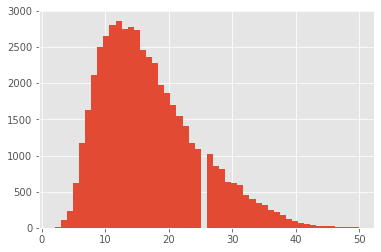

In [183]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [184]:
# create set of unique words and add ENDPAD as last element
words = list(set(df["word"].values))
words.append("ENDPAD")

In [185]:
n_words = len(words) 
n_words

120162

In [186]:
tags = list(set(df["tag"].values))
tags

['I-LOCATION',
 'B-ORGANIZATION',
 'I-MISC',
 'B-PERSON',
 'B-LOCATION',
 'B-MISC',
 'I-ORGANIZATION',
 'O',
 'I-PERSON']

In [187]:
n_tags = len(tags); n_tags

9

In [188]:
# creating index dictionaries for words and tags
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [189]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=n_words - 1)

In [190]:
# We append "O" tags end of each sentence that smaller than 50.
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y_idx, padding="post", value=tag2idx["O"])

In [191]:
print(y_idx[2])

[3, 8, 7, 5, 7, 7]


In [192]:
len(y) # it should be equal longest sentence length

50001

In [193]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [194]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [195]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
import time
print(k.__version__)

2.2.4


In [204]:
!pip install gensim

In [243]:
from gensim.models import Word2Vec, FastText
from keras.preprocessing.text import Tokenizer

def get_word2vec_embeddding_layer(embedding_size, input_shape):
    tokenizer = Tokenizer()
    # Train Word2Vec model with gensim on the dataset
    w2v_model = Word2Vec(words, size=embedding_size, workers=8)

    embedding_matrix_w2v = np.random.random(((n_words) + 1, embedding_size))
    for word,i in tokenizer.word_index.items():  
      try:
          embedding_matrix_w2v[i] = w2v_model.wv[word]
      except:
          pass

    # create layer
    embedding_layer_w2v = Embedding(n_words+1, output_dim=embedding_size, weights=[embedding_matrix_w2v], input_length=input_shape, trainable=True)
    
    return embedding_layer_w2v

In [244]:
# input shape should be equal to the longest input length
def prepare_model(input_shape, embedding_size, learning_rate, embedding_spec=0):
  input = Input(shape=(input_shape,))
  
  if embedding_spec == 0: # for keras embeddding
      embedding = Embedding(input_dim=n_words, output_dim=embedding_size, input_length=input_shape)
  elif embedding_spec == 1: # for word2vec embedding
      embedding = get_word2vec_embeddding_layer(embedding_size, input_shape)
      
  model = embedding(input)
  model = Bidirectional(LSTM(units=embedding_size, 
                          return_sequences=True, 
                          dropout=0.5, 
                          recurrent_dropout=0.5, 
                          kernel_initializer=k.initializers.he_normal()))(model)
  model = LSTM(units=embedding_size * 2, 
              return_sequences=True, 
              dropout=0.5, 
              recurrent_dropout=0.5, 
              kernel_initializer=k.initializers.he_normal())(model)
  model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # previously softmax output layer

  crf = CRF(n_tags)  # CRF layer
  out = crf(model)  # output

  model = Model(input, out)

  adam = k.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
  #model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
  model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
  
  return model

In [245]:
model = prepare_model(max_len,300, 0.01,1)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 50, 300)           36048900  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 50, 600)           1442400   
_________________________________________________________________
lstm_16 (LSTM)               (None, 50, 600)           2882400   
_________________________________________________________________
time_distributed_8 (TimeDist (None, 50, 9)             5409      
_________________________________________________________________
crf_8 (CRF)                  (None, 50, 9)             189       
Total params: 40,379,298
Trainable params: 40,379,298
Non-trainable params: 0
________________________________________________________________

In [246]:
# Saving the best only
def train_model(model):
  """filepath=get_path("ner-bi-lstm-td-model-{val_acc:.2f}.hdf5")
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint] -> , callbacks=callbacks_list"""
  history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.2, verbose=1)
  return history, model

def save_model(model, *attr):
  timestamp = int(round(time.time() * 1000))
  file_name = "ner_bi_lstm_crf_model_"+"_".join(attr)+f"_{timestamp}.h5"
  model_save_path = get_path(file_name)
  model.save_weights(model_save_path)

In [247]:
history, trained_model = train_model(model)
save_model(trained_model,"50","300","0.01")

Train on 32000 samples, validate on 8000 samples
Epoch 1/20
 1280/32000 [>.............................] - ETA: 26:11 - loss: 1.0732 - crf_viterbi_accuracy: 0.6266 - acc: 0.0016

KeyboardInterrupt: ignored

In [ ]:
# model evaluation metrics
def set_default_evulation_metrics():
  TP = {}
  TN = {}
  FP = {}
  FN = {}
  
  for tag in tag2idx.keys():
      TP[tag] = 0
      TN[tag] = 0    
      FP[tag] = 0    
      FN[tag] = 0    


def accumulate_score_by_tag(gt, pred):
  
  
  """
  For each tag keep stats
  """
  if gt == pred:
      TP[gt] += 1
  elif gt != 'O' and pred == 'O':
      FN[gt] +=1
  elif gt == 'O' and pred != 'O':
      FP[gt] += 1
  else:
      TN[gt] += 1

In [ ]:
# Single prediction and verbose results
i = 10
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
print(gt)
print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
    #
    print("{:14}: ({:5}): {}".format(words[w],idx2tag[gt[idx]],tags[pred]))

In [ ]:
def test_model(model,x_test,y_test):
  p = model.predict(np.array(x_test))

  from sklearn.metrics import classification_report

  print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))
  
  set_default_evulation_metrics()
  # acumulate the scores by tag
  for i, sentence in enumerate(x_test):
      y_hat = np.argmax(p[i], axis=-1)
      gt = np.argmax(y_test[i], axis=-1)
      for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
          accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

  for tag in tag2idx.keys():
      print(f'tag:{tag}')    
      print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
      print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))  

In [ ]:
test_model(model,X_test,y_test)

In [ ]:
# load model from save and test
from keras.models import load_model
model = prepare_model(50,300,0.01)
trained_model_path = get_path("ner_bi_lstm_crf_model_50_300_0.01_1621337204296.h5")
model.load_weights(trained_model_path)
test_model(model,X_test,y_test)
